In [1]:
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pillow_heif import register_heif_opener
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

register_heif_opener()

In [2]:
device = torch.device("cuda")

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    
    def forward(self, x, resid):
        x = F.relu(self.up_conv(x))
        assert x.shape == resid.shape
        x = torch.cat((resid, x), dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.enc1 = EncoderBlock(64, 128)
        self.enc2 = EncoderBlock(128, 256)
        self.enc3 = EncoderBlock(256, 512)
        self.enc4 = EncoderBlock(512, 1024)
        self.dec4 = DecoderBlock(1024, 512)
        self.dec3 = DecoderBlock(512, 256)
        self.dec2 = DecoderBlock(256, 128)
        self.dec1 = DecoderBlock(128, 64)
        self.head = nn.Conv2d(64, 3, 1, padding='same')
        self.k = nn.Parameter(torch.tensor(2.))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x0 = x
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x = self.enc4(x3)

        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)
        x = self.head(x)
        x = self.k * torch.tanh(x)
        return x

In [3]:
model = UNet().to(device)

In [4]:
class ColoringDataset(Dataset):
    def __init__(self, train):
        if train:
            base_path = "train_images"
            self.transforms = A.Compose([
                A.SmallestMaxSize(int(512 * 3 / 2)),
                A.RandomCrop(height=384, width=512),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])
        else:
            base_path = "old_dataset/val_images"
            self.transforms = A.Compose([
                A.Resize(height=384, width=512),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ])

        self.image_paths = glob("%s/*.*" % base_path)
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = np.array(image)
        image = self.transforms(image=image)["image"]

        grey_image = torch.mean(image, dim=0, keepdim=True)
        return grey_image, image

In [5]:
train_dataset = ColoringDataset(train=True)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=8)

val_dataset = ColoringDataset(train=False)
val_data_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [6]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
NUM_EPOCH = 5

step = 0
for i in range(NUM_EPOCH):

    for x, y in train_data_loader:
        model.train()
        x = x.to(device)
        y = y.to(device)
    
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_func(outputs, y)
        loss.backward()
        optimizer.step()
        step += 1
        if step % 100 == 0:
            print("train loss: ", loss.item())
            model.eval()
            for x, y in val_data_loader:
                x = x.to(device)
                y = y.to(device)
            
                with torch.no_grad():
                    outputs = model(x)
                    loss = loss_func(outputs, y)
                    print("val loss: ", loss.item())

train loss:  0.2068532109260559
val loss:  0.19733977317810059
train loss:  0.11445910483598709
val loss:  0.17169718444347382
train loss:  0.10484317690134048
val loss:  0.1776658296585083
train loss:  0.09189936518669128
val loss:  0.1874041110277176
train loss:  0.1488964557647705
val loss:  0.15521366894245148
train loss:  0.10850071907043457
val loss:  0.18420590460300446
train loss:  0.06938689202070236
val loss:  0.17866063117980957
train loss:  0.148057758808136
val loss:  0.15911038219928741
train loss:  0.102566659450531
val loss:  0.15820802748203278
train loss:  0.07639501988887787
val loss:  0.1750047355890274
train loss:  0.11491041630506516
val loss:  0.16411277651786804
train loss:  0.11125513166189194
val loss:  0.15806664526462555
train loss:  0.06755336374044418
val loss:  0.16511568427085876
train loss:  0.07088974863290787
val loss:  0.15886543691158295
train loss:  0.12845341861248016
val loss:  0.17057445645332336
train loss:  0.11329325288534164
val loss:  0.144

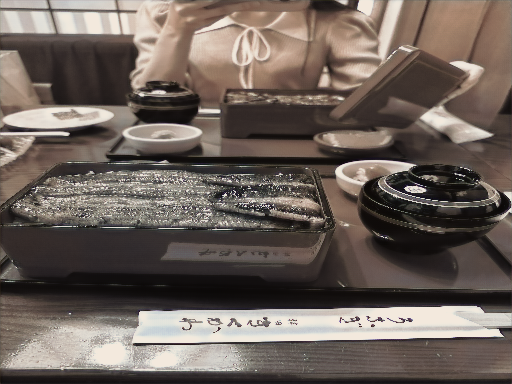

In [8]:
x, y = next(iter(val_data_loader))
x = x.to(device)

with torch.no_grad():
    output = model(x)
    output = output[0].permute((1, 2, 0))
    output *= torch.tensor([0.229, 0.224, 0.225], device=device) * 255.0
    output += torch.tensor([0.485, 0.456, 0.406], device=device) * 255.0
    output = torch.clamp(output.byte(), 0, 255)
    output = output.cpu().numpy()

Image.fromarray(output)

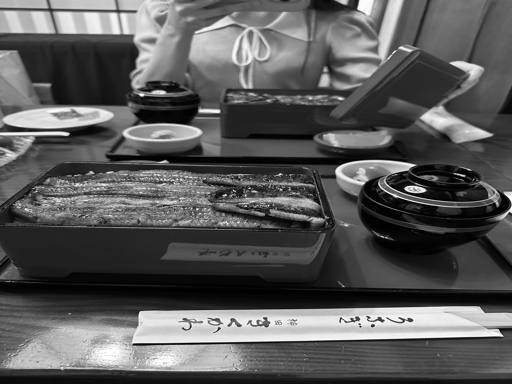

In [9]:
Image.open("old_dataset/val_images/IMG_1975.HEIC").resize((512,384)).convert('L')

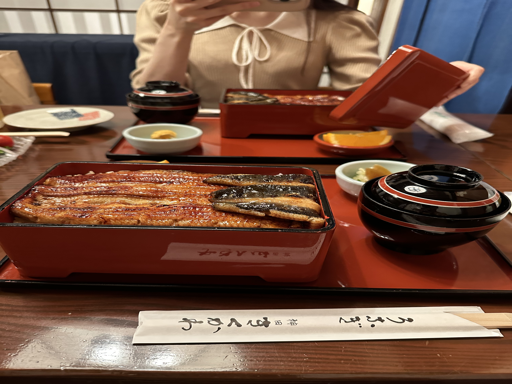

In [10]:
Image.open("old_dataset/val_images/IMG_1975.HEIC").resize((512,384))